In [57]:
from datetime import date, timedelta
from scipy import stats

from itertools import product
from statsmodels import tsa
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARMAResults 
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
import warnings

warnings.simplefilter('ignore')

In [2]:
PATH = '../Data/transact_18_22/transact_18_22.csv'
df = pd.read_csv(PATH)
df.head()

,client,card,date,amt,mcc,group,value
0,390989,3048567,2018-01-01,878.0,5814,food,survival
1,1309946,3226559,2018-01-01,249.0,5411,food,survival
2,1386278,2715990,2018-01-01,50.0,5499,food,survival
3,475694,2884069,2018-01-01,2564.0,5941,fun,self_realization
4,710293,3396065,2018-01-01,464.9,5814,food,survival


In [3]:
value_categories = ['survival', 'socialization', 'money', 'self_realization']
df_filtered = df[df['value'].isin(value_categories)]
df_filtered['value'].value_counts()

survival            11898943
socialization        3462139
money                1968121
self_realization     1697659
Name: value, dtype: int64

In [4]:
data = df_filtered.groupby('date').sum()
data.head()

,client,card,amt,mcc
date,,,,
2018-01-01,4394496797,6565684643,2769662.31,12741033
2018-01-02,8335815941,12562890532,6585441.32,24429968
2018-01-03,10082487018,15256762910,7891523.29,29759173
2018-01-04,9833983757,14649295462,8273468.59,28971441
2018-01-05,10798124761,16124956202,8638770.26,31537355


In [5]:
df_weekly_sum = data.copy()
df_weekly_sum.index = pd.to_datetime(df_weekly_sum.index)
df_weekly_sum.head()

,client,card,amt,mcc
date,,,,
2018-01-01,4394496797,6565684643,2769662.31,12741033
2018-01-02,8335815941,12562890532,6585441.32,24429968
2018-01-03,10082487018,15256762910,7891523.29,29759173
2018-01-04,9833983757,14649295462,8273468.59,28971441
2018-01-05,10798124761,16124956202,8638770.26,31537355


In [6]:
df_weekly_sum = df_weekly_sum.resample('W').sum()
df_weekly_sum.head()

,client,card,amt,mcc
date,,,,
2018-01-07,63547496109,95199343521,4.931311e+07,185989327
2018-01-14,90804697635,135591245197,1.081436e+08,262368300
2018-01-21,90455344549,134952405476,1.051826e+08,261806275
2018-01-28,95845182851,145090521979,1.055354e+08,278454711
2018-02-04,89407975138,136760041862,9.132034e+07,260285423


In [7]:
EPS = 10 ** (-6)
def get_norm_data(df, col):
    return (df[col] - df[col].min()) / (df[col].max() - df[col].min()) + EPS

In [8]:
sample = df_weekly_sum[['amt']]

In [9]:

# Лучший набор параметров для модели трат, обученной до 2019 года включительно
best_param = (3, 3, 0, 0)
d = 1
D = 1
S = 52
# Ключ в словаре - это дата, до которой включительно обучалась модель
spending_models = {}

for i in tqdm(range(131)):
    # разбиение данных на train/test
    train_threshold = pd.to_datetime('2019-12-29') + timedelta(days=(7 * i)) 
    train_data = sample.loc[:train_threshold]
    test_data = sample.loc[train_threshold + timedelta(days=1):]
    
    # предварительная подготовка данных для обучения
    train_data['norm'] = get_norm_data(train_data, 'amt')
    train_data['norm_box'], lmbda = stats.boxcox(train_data.norm)
    # обучение модели
    current_model = SARIMAX(
        train_data.norm_box, 
        order=(best_param[0], d, best_param[1]),
        seasonal_order=(best_param[2], D, best_param[3], S)
    )
    
    fitted_model = current_model.fit()

    idx = pd.to_datetime('2019-12-29') + timedelta(days=(7 * (i + 1))) 
    spending_models[idx] = {
        'model': current_model,
        'params': dict(fitted_model.params),
        'min_value': train_data['amt'].min(),
        'max_value': train_data['amt'].max(),
        'lmbda': lmbda,
    }
    

100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [13:00<00:00,  5.96s/it]


In [10]:
# Сохранение полученных результатов в файл
results_arr = []
for k, v in spending_models.items():
    cur_df = pd.DataFrame.from_dict(v['params'], orient='index').T
    cur_df['min_value'] = v['min_value']
    cur_df['max_value'] = v['max_value']
    cur_df['lmbda'] = v['lmbda']
    results_arr.append(cur_df)

df_results = pd.concat(results_arr)
df_results.reset_index(drop=True, inplace=True)
df_results['week'] = spending_models.keys()
df_results.head()

,ar.L1,ar.L2,ar.L3,ma.L1,ma.L2,ma.L3,sigma2,min_value,max_value,lmbda,week
0,-0.417448,-0.321296,-0.351902,-0.841730,0.428165,-0.126455,0.003634,49313105.58,2.202029e+08,0.814824,2020-01-05
1,-1.217909,-1.075369,-0.432186,0.005854,0.316390,-0.792045,0.004210,49313105.58,2.202029e+08,0.811815,2020-01-12
2,-0.276708,-0.597449,-0.535387,-1.002981,0.909707,-0.392091,0.004672,49313105.58,2.202029e+08,0.810131,2020-01-19
3,-0.601104,-0.994365,-0.592476,-0.655914,0.949300,-0.682520,0.004397,49313105.58,2.202029e+08,0.813802,2020-01-26
4,-0.604706,-0.984193,-0.583691,-0.644481,0.908236,-0.640625,0.004439,49313105.58,2.202029e+08,0.816255,2020-02-02


In [11]:
df_results.to_csv('../Data/spending_params_sarimax.csv', sep=';', index=False)

### Вспомогательные функции для обучения различных комбинаций моделей

In [12]:
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))


def transform_final_prediction(model, days, test_data, column_name, lmbda, min_value, max_value):
    # трансформация полученных предсказанных результатов в траты
    tmp_pred = invboxcox(model.forecast(days), lmbda)
    test_data[column_name] = tmp_pred
    return (test_data[column_name] - EPS) * (max_value - min_value) + min_value



In [13]:
def get_df_metric(df, base_col, add_cols, metric, days):
    tmp = dict()
    for add_col in add_cols:
        col_res = []
        for day in days:
            col_res.append(metric(df[base_col][:day], df[add_col][:day]))
        tmp[add_col] = col_res
    return pd.DataFrame(tmp, index=days)

days = [1, 2, 4, 8, 12]

In [14]:
def shift_sarimax_params(params, shift):
    
    def shift_key(k, shift):
        if k.count('.') == 2:
            return k
        tokens = k.split('L')
        new_version = int(tokens[1]) + shift
        tokens[1] = str(new_version)
        return 'L'.join(tokens)
    
    return {
        shift_key(k, shift): v
        for k, v in params.items()
    }

def add_weight_to_params(params, weight):
    return {
        k: [v, weight] for k, v in params.items()
    }

In [15]:
def get_additional_params(deposit_params, news_params, deposit_weight, news_weight, with_shift=False):
    
    weighted_deposit_params = add_weight_to_params(deposit_params, deposit_weight)
    weighted_news_params = add_weight_to_params(news_params, news_weight)
    
    additional_params = {
        '': [],
        ' + deposit': [weighted_deposit_params],
        ' + news': [weighted_news_params],
        ' + deposit + news': [weighted_deposit_params, weighted_news_params]
    }
    
    if with_shift:
        shifted_deposit_params_1 = shift_sarimax_params(deposit_params, 1)
        shifted_deposit_params_2 = shift_sarimax_params(deposit_params, 2)
        shifted_news_params_1 = shift_sarimax_params(news_params, -1)
        shifted_news_params_2 = shift_sarimax_params(news_params, -2)
        
        weighted_shifted_deposit_params_1 = add_weight_to_params(shifted_deposit_params_1, deposit_weight)
        weighted_shifted_deposit_params_2 = add_weight_to_params(shifted_deposit_params_2, deposit_weight)
        weighted_shifted_news_params_1 = add_weight_to_params(shifted_news_params_1, news_weight)
        weighted_shifted_news_params_2 = add_weight_to_params(shifted_news_params_2, news_weight)
        
        additional_params.update({
            ' + deposit(+1)': [weighted_shifted_deposit_params_1],
            ' + news(-1)': [weighted_shifted_news_params_1],
            ' + deposit(+1) + news(-1)': [weighted_shifted_deposit_params_1, weighted_shifted_news_params_1],
            ' + deposit(+2)': [weighted_shifted_deposit_params_2],
            ' + news(-2)': [weighted_shifted_news_params_2],
            ' + deposit(+2) + news(-2)': [weighted_shifted_deposit_params_2, weighted_shifted_news_params_2],
        })

    additional_params = {
        'spendings' + k : v
        for k, v in additional_params.items()
    }
    
    return additional_params

### Подготовка данных из других контуров

In [16]:
# Общие коэффициенты, которые планируется брать из моделей
common_coeffs = ['ar.L1', 'ar.L2', 'ma.L1', 'ma.L2']

Данные по депозитам

In [17]:
df_deposit = pd.read_csv('../Data/deposit_params_20.csv', sep=';')
df_deposit.head()

,End date,ar.L1,ar.L2,ar.L3,ma.L1,ma.L2,ma.S.L52
0,05.01.2020,-0.181906,0.139188,0.118634,-0.632538,-0.173210,-0.891997
1,12.01.2020,-0.144522,0.135262,0.120512,-0.694783,-0.121045,0.822355
2,19.01.2020,-0.116649,0.122556,0.112481,-0.713522,-0.104540,-0.852798
3,26.01.2020,-0.117825,0.123186,0.111670,-0.712201,-0.105639,-0.857375
4,02.02.2020,-0.103193,0.120140,0.104649,-0.726722,-0.091894,-0.868807


In [18]:
df_deposit.shape

(170, 7)

In [19]:
df_deposit.drop_duplicates(keep='first', inplace=True)
df_deposit.reset_index(drop=True, inplace=True)
df_deposit['End date'] = pd.to_datetime(df_deposit['End date'].astype('str'), format='%d.%m.%Y')
df_deposit.head()

,End date,ar.L1,ar.L2,ar.L3,ma.L1,ma.L2,ma.S.L52
0,2020-01-05,-0.181906,0.139188,0.118634,-0.632538,-0.173210,-0.891997
1,2020-01-12,-0.144522,0.135262,0.120512,-0.694783,-0.121045,0.822355
2,2020-01-19,-0.116649,0.122556,0.112481,-0.713522,-0.104540,-0.852798
3,2020-01-26,-0.117825,0.123186,0.111670,-0.712201,-0.105639,-0.857375
4,2020-02-02,-0.103193,0.120140,0.104649,-0.726722,-0.091894,-0.868807


In [20]:
df_deposit = df_deposit[:-1]
df_deposit.tail()

,End date,ar.L1,ar.L2,ar.L3,ma.L1,ma.L2,ma.S.L52
126,2022-06-05,-0.719939,0.168892,-0.016891,0.090520,-0.802424,-0.982805
127,2022-06-12,-0.702615,0.172374,-0.030181,0.094297,-0.801701,-0.965074
128,2022-06-19,0.691566,0.178688,0.024585,0.085646,-0.796321,-0.962748
129,2022-06-26,-0.686271,0.177115,-0.026133,0.079903,-0.794090,-0.961417
130,2022-07-03,-0.677200,0.180832,-0.023500,0.071792,-0.793415,-0.981987


In [21]:
deposit_params = df_deposit[common_coeffs].to_dict(orient='records')

Данные по новостям

In [22]:
df_news = pd.read_csv('../Data/params_crisis_13122023.csv', sep=',')
df_news.head()

,week,ar.L1,ar.L2,ma.L1,ma.L2,ar.S.L52,ma.S.L52,sigma2,aic
0,2019-12-29,-0.774452,0.001480,0.039524,-0.615387,-0.257077,-0.542724,0.012872,-184.792532
1,2020-01-05,-0.778992,-0.002016,0.051772,-0.599316,-0.214688,-0.569445,0.012701,-184.772280
2,2020-01-12,-0.765484,0.003631,0.026995,-0.609305,-0.247970,-0.535361,0.012984,-186.774503
3,2020-01-19,-0.760421,0.012550,0.025882,-0.619466,-0.233757,-0.543026,0.013060,-187.250353
4,2020-01-26,-0.765061,0.006562,0.032358,-0.611716,-0.230420,-0.565066,0.012804,-189.730977


In [23]:
df_news.tail()

,week,ar.L1,ar.L2,ma.L1,ma.L2,ar.S.L52,ma.S.L52,sigma2,aic
127,2022-06-05,-1.754834,-0.953167,1.756884,0.981312,-0.901998,0.706479,0.022608,-226.777450
128,2022-06-12,-1.820235,-0.999267,1.814330,0.987185,-0.543486,-0.270930,0.019185,-272.560051
129,2022-06-19,-1.764577,-0.985337,1.691243,0.913343,-0.177263,-0.686201,0.015992,-305.862211
130,2022-06-26,-1.793245,-0.981124,1.786116,0.983885,-0.927148,0.721392,0.023057,-228.055835
131,2022-07-03,-1.771506,-0.964903,1.764175,0.968265,-0.374116,-0.514885,0.015988,-301.361073


In [24]:
df_news['week'] = pd.to_datetime(df_news['week'].astype('str'))
df_news.head()

,week,ar.L1,ar.L2,ma.L1,ma.L2,ar.S.L52,ma.S.L52,sigma2,aic
0,2019-12-29,-0.774452,0.001480,0.039524,-0.615387,-0.257077,-0.542724,0.012872,-184.792532
1,2020-01-05,-0.778992,-0.002016,0.051772,-0.599316,-0.214688,-0.569445,0.012701,-184.772280
2,2020-01-12,-0.765484,0.003631,0.026995,-0.609305,-0.247970,-0.535361,0.012984,-186.774503
3,2020-01-19,-0.760421,0.012550,0.025882,-0.619466,-0.233757,-0.543026,0.013060,-187.250353
4,2020-01-26,-0.765061,0.006562,0.032358,-0.611716,-0.230420,-0.565066,0.012804,-189.730977


In [25]:
news_params = df_news[common_coeffs].to_dict(orient='records')
print(len(news_params))

132


In [26]:
deposit_params_mapping = {
    date: deposit_params[i]
    for i, date in enumerate(spending_models.keys())
}

news_params_mapping = {
    date: news_params[i]
    for i, date in enumerate(spending_models.keys())
}

print(len(deposit_params_mapping), len(news_params_mapping))

131 131


In [28]:
def use_weight(model_params, base_weight, base_coeffs, other_weight):
    return {
        k: v * base_weight if k in base_coeffs else v * other_weight
        for (k, v) in model_params.items()
    }


In [29]:
# пример весов моделей
model_weights = [
    (0.9, -0.05, -0.05), 
    (0.9, 0.05, 0.05), 
]

In [30]:
def final_params_aggregation(arr):
    coefs = [item[0] for item in arr]
    weights = [item[1] for item in arr]
    return sum([coef * weight for coef, weight in zip(coefs, weights)]) / sum(weights)

### Перебор различных комбинаций контуров и весов

In [31]:
final_results = {}

for (spending_weight, deposit_weight, news_weight) in tqdm(model_weights):
    weight_results = {}
    for date in list(spending_models.keys()):
        current_model = spending_models[date]['model']
        cur_params = spending_models[date]['params']
        shift_date = 0
        current_test = sample.loc[date + timedelta(days=shift_date):date + timedelta(days=7 * max(days)):].copy()

        # формирование коэффициентов новых моделей
        cur_deposit_params = deposit_params_mapping[date]
        cur_news_params = news_params_mapping[date]
        additional_params = get_additional_params(
            cur_deposit_params, cur_news_params, deposit_weight, news_weight, with_shift=True
        )

        # получение предсказания
        for prediction_col_name, params_arr in additional_params.items():
            
            # объединение разных параметров. 
            new_params = {k: [[v, spending_weight]] for k, v in cur_params.items()}
            for params_item in params_arr:
                for coef in new_params:
                    if coef in params_item:
                        new_params[coef].append(params_item[coef])
            new_params = {k: final_params_aggregation(value) for k, value in new_params.items()}
            with current_model.fix_params(new_params):
                cur_res = current_model.fit_constrained(new_params)
                current_test[prediction_col_name] = transform_final_prediction(
                    cur_res, 
                    len(current_test),
                    current_test, 
                    prediction_col_name,
                    spending_models[date]['lmbda'],
                    spending_models[date]['min_value'],
                    spending_models[date]['max_value'],
                )

        current_test.rename({'amt': 'real_amount'}, axis=1, inplace=True)
        current_test.dropna(axis=1, inplace=True)
        prediction_col_names = current_test.columns[1:]
        df_metrics = get_df_metric(current_test, 'real_amount', prediction_col_names, mean_absolute_percentage_error, days)

        weight_results[date] = {
            'predictions': current_test.copy(),
            'metrics': df_metrics.copy(),
        }
    
    final_results[(spending_weight, deposit_weight, news_weight)] = weight_results.copy()

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [15:32<00:00, 466.39s/it]


In [33]:
# пример прогноза
current_test.head()

,real_amount,spendings,spendings + deposit,spendings + news,spendings + deposit + news,spendings + deposit(+1),spendings + news(-1),spendings + deposit(+1) + news(-1),spendings + deposit(+2),spendings + news(-2),spendings + deposit(+2) + news(-2)
date,,,,,,,,,,,
2022-07-03,1.462436e+08,1.448969e+08,1.447415e+08,1.450543e+08,1.447224e+08,1.447801e+08,1.448969e+08,1.447629e+08,1.448563e+08,1.448969e+08,1.448563e+08
2022-07-10,1.332004e+08,1.328268e+08,1.328291e+08,1.326181e+08,1.325380e+08,1.328238e+08,1.326241e+08,1.325970e+08,1.328378e+08,1.328268e+08,1.328378e+08
2022-07-17,1.471313e+08,1.507385e+08,1.508149e+08,1.509873e+08,1.510540e+08,1.508293e+08,1.508748e+08,1.509541e+08,1.506941e+08,1.507385e+08,1.506941e+08
2022-07-24,1.230877e+08,1.303430e+08,1.302485e+08,1.305120e+08,1.303461e+08,1.303407e+08,1.303916e+08,1.303786e+08,1.303416e+08,1.303430e+08,1.303416e+08
2022-07-31,1.268024e+08,1.260634e+08,1.259826e+08,1.260169e+08,1.258699e+08,1.259668e+08,1.260004e+08,1.258827e+08,1.261068e+08,1.260634e+08,1.261068e+08


In [34]:
# пример метрики
df_metrics.head()

,spendings,spendings + deposit,spendings + news,spendings + deposit + news,spendings + deposit(+1),spendings + news(-1),spendings + deposit(+1) + news(-1),spendings + deposit(+2),spendings + news(-2),spendings + deposit(+2) + news(-2)
1,0.009208,0.010271,0.008132,0.010402,0.010007,0.009208,0.010125,0.009486,0.009208,0.009486
2,0.006007,0.006529,0.006252,0.007687,0.006417,0.006768,0.007328,0.006104,0.006007,0.006104
4,0.023869,0.024068,0.024757,0.025251,0.024223,0.024579,0.024967,0.023839,0.023869,0.023839
8,1.534925,1.534326,1.536940,1.535572,1.535179,1.535536,1.535566,1.534761,1.534925,1.534761
12,1.534925,1.534326,1.536940,1.535572,1.535179,1.535536,1.535566,1.534761,1.534925,1.534761


# Просмотр результатов

In [40]:
idx = 1
current_results = list(final_results.values())[idx] 
print(list(final_results.keys())[idx])

(0.9, 0.05, 0.05)


In [41]:
mean_metrics = {}
df_for_concat = []
best_columns = set(list(current_results.values())[idx]['metrics'].columns)

# для рассмотрения берутся только те комбинации моделей, у которых в прогнозе нет null
for i in range(len(current_results)):
    cur_df_metrics = list(current_results.values())[i]['metrics']
    best_columns = best_columns & set(cur_df_metrics.columns)

for i in range(len(current_results)):
    cur_df_metrics = list(current_results.values())[i]['metrics']
    df_for_concat.append(cur_df_metrics[list(best_columns)])

print(best_columns)

{'spendings + deposit', 'spendings', 'spendings + deposit(+2)', 'spendings + news', 'spendings + deposit(+1) + news(-1)', 'spendings + deposit + news', 'spendings + news(-2)', 'spendings + deposit(+1)', 'spendings + deposit(+2) + news(-2)'}


In [42]:
merged_df_metrics = pd.concat(df_for_concat)
average_metrics = []
for day in days:
    cur_metric_df = merged_df_metrics[merged_df_metrics.index == day]
    average_metrics.append(
        pd.DataFrame(cur_metric_df.mean(axis=0)).T

    )

average_df_metrics = pd.DataFrame(pd.concat(average_metrics, axis=0))

average_df_metrics.head()

,spendings + deposit,spendings,spendings + deposit(+2),spendings + news,spendings + deposit(+1) + news(-1),spendings + deposit + news,spendings + news(-2),spendings + deposit(+1),spendings + deposit(+2) + news(-2)
0,0.100917,0.101748,0.101920,0.101476,0.101488,0.100285,0.101748,0.101487,0.101920
0,0.101972,0.102870,0.103084,0.102662,0.102448,0.101810,0.102870,0.102488,0.103084
0,0.104749,0.105574,0.105960,0.105210,0.104665,0.104512,0.105574,0.104610,0.105960
0,0.120614,0.121576,0.121861,0.121191,0.120706,0.120252,0.121576,0.120438,0.121861
0,0.159138,0.160188,0.160484,0.159846,0.159233,0.158880,0.160188,0.158865,0.160484


In [43]:
average_df_metrics.index = days
average_df_metrics.head()

,spendings + deposit,spendings,spendings + deposit(+2),spendings + news,spendings + deposit(+1) + news(-1),spendings + deposit + news,spendings + news(-2),spendings + deposit(+1),spendings + deposit(+2) + news(-2)
1,0.100917,0.101748,0.101920,0.101476,0.101488,0.100285,0.101748,0.101487,0.101920
2,0.101972,0.102870,0.103084,0.102662,0.102448,0.101810,0.102870,0.102488,0.103084
4,0.104749,0.105574,0.105960,0.105210,0.104665,0.104512,0.105574,0.104610,0.105960
8,0.120614,0.121576,0.121861,0.121191,0.120706,0.120252,0.121576,0.120438,0.121861
12,0.159138,0.160188,0.160484,0.159846,0.159233,0.158880,0.160188,0.158865,0.160484


In [44]:
average_df_metrics.style.highlight_min(color = 'lightgreen', axis = 1)

,spendings + deposit,spendings,spendings + deposit(+2),spendings + news,spendings + deposit(+1) + news(-1),spendings + deposit + news,spendings + news(-2),spendings + deposit(+1),spendings + deposit(+2) + news(-2)
1,0.100917,0.101748,0.101920,0.101476,0.101488,0.100285,0.101748,0.101487,0.101920
2,0.101972,0.102870,0.103084,0.102662,0.102448,0.101810,0.102870,0.102488,0.103084
4,0.104749,0.105574,0.105960,0.105210,0.104665,0.104512,0.105574,0.104610,0.105960
8,0.120614,0.121576,0.121861,0.121191,0.120706,0.120252,0.121576,0.120438,0.121861
12,0.159138,0.160188,0.160484,0.159846,0.159233,0.158880,0.160188,0.158865,0.160484


In [45]:
def get_percent_df(df):
    algorithms = df.columns.unique()
    result = pd.DataFrame({'spendings': [0 for _ in range(len(df))]})
    
    for algorithm in algorithms:
        algorithm_rmse = df[algorithm]
        base_rmse = df['spendings']
        pct_diff = ((base_rmse - algorithm_rmse) / base_rmse) * 100
        result[algorithm] = pct_diff.values
        
    return result

df_percent = get_percent_df(average_df_metrics)
df_percent.style.highlight_max(color = 'lightgreen', axis = 1)


,spendings,spendings + deposit,spendings + deposit(+2),spendings + news,spendings + deposit(+1) + news(-1),spendings + deposit + news,spendings + news(-2),spendings + deposit(+1),spendings + deposit(+2) + news(-2)
0,0.000000,0.815963,-0.168960,0.267238,0.254953,1.437704,0.000000,0.255985,-0.168960
1,0.000000,0.873396,-0.207728,0.202934,0.410791,1.030617,0.000000,0.372150,-0.207728
2,0.000000,0.781822,-0.365742,0.345398,0.861064,1.006309,0.000000,0.912949,-0.365742
3,0.000000,0.790889,-0.235140,0.316678,0.715578,1.088536,0.000000,0.935587,-0.235140
4,0.000000,0.655176,-0.184683,0.213343,0.596303,0.816235,0.000000,0.825568,-0.184683


### Визуализация работы моделей в кризисы

In [52]:
cur_timestamp = pd.Timestamp('2020-03-08 00:00:00') + timedelta(days=0)
example_week = current_results[cur_timestamp]
plot_test = example_week['predictions']
metrics_test = example_week['metrics']

In [53]:
metrics_test[best_columns].style.highlight_min(color = 'lightgreen', axis = 1)

,spendings + deposit,spendings,spendings + deposit(+2),spendings + news,spendings + deposit(+1) + news(-1),spendings + deposit + news,spendings + news(-2),spendings + deposit(+1),spendings + deposit(+2) + news(-2)
1,0.087994,0.096520,0.102342,0.089623,0.082990,0.080583,0.096520,0.098508,0.102342
2,0.069116,0.065207,0.067818,0.070021,0.058665,0.071880,0.065207,0.067579,0.067818
4,0.057379,0.053189,0.052176,0.057916,0.051186,0.060747,0.053189,0.052204,0.052176
8,0.229137,0.230509,0.230807,0.229783,0.227327,0.228436,0.230509,0.229954,0.230807
12,0.229575,0.232263,0.232679,0.230195,0.229051,0.227846,0.232263,0.231513,0.232679


In [54]:
df_percent = get_percent_df(metrics_test)
df_percent.index = days
df_percent[best_columns].style.highlight_max(color = 'lightgreen', axis = 1)

,spendings + deposit,spendings,spendings + deposit(+2),spendings + news,spendings + deposit(+1) + news(-1),spendings + deposit + news,spendings + news(-2),spendings + deposit(+1),spendings + deposit(+2) + news(-2)
1,8.833290,0.000000,-6.032179,7.145386,14.017468,16.511290,0.000000,-2.059149,-6.032179
2,-5.994781,0.000000,-4.003887,-7.382143,10.032449,-10.234145,0.000000,-3.638311,-4.003887
4,-7.876572,0.000000,1.904539,-8.885850,3.765890,-14.209051,0.000000,1.851781,1.904539
8,0.595126,0.000000,-0.129221,0.314932,1.380384,0.899359,0.000000,0.240889,-0.129221
12,1.157393,0.000000,-0.178937,0.890169,1.382826,1.901564,0.000000,0.322918,-0.178937


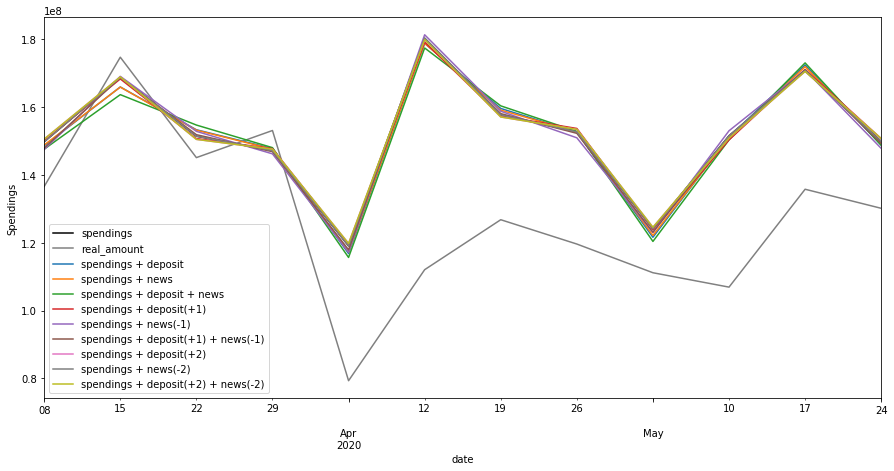

In [56]:
LEN = 12
plt.figure(figsize=(15, 7))
plot_test['spendings'][:LEN].plot(c='black')
plot_test['real_amount'][:LEN].plot(c='grey')
for col in plot_test.columns[2:]:
    plot_test[col][:LEN].plot()
plt.ylabel('Spendings')
plt.legend()
plt.show()